# Тетрадка для проведения кластеризации

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd 
import numpy as np 
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import bcubed

import warnings
warnings.filterwarnings("ignore")

In [31]:
def split_scores(num_groups, df): #bcubed table
    df_sorted = df.sort_values(by='index')
    quantiles = pd.qcut(df_sorted['index'], q=num_groups, labels=False)
    df_sorted['group'] = quantiles
    df_sorted = df_sorted.reset_index(drop=True)
    data = df_sorted[['bank_name', 'group']].set_index('bank_name')
    data['group'] = data['group'].apply(lambda x: set([str(x)]))
    clusters = data.T.to_dict('records')[0]
    return clusters

def form_equal_dict(dict1, dict2):
    if len(dict1.keys()) >= len(dict2.keys()):
        bigger = dict1
        smaller = dict2
    else:
        smaller = dict1
        bigger = dict2

    bigger = {k: v for (k,v) in bigger.items() if k in smaller.keys()}
    return bigger, smaller

In [31]:
!pip install bcubed

  Obtaining dependency information for bcubed from https://files.pythonhosted.org/packages/56/c4/f06199a7de2236e92d3894672b1f8530d4fc1c02d7453d6c30e379fbce41/bcubed-1.5-py2.py3-none-any.whl.metadata


In [4]:
x_2023 = pd.read_excel('full_dfs/x_2023.xlsx')
index_data = pd.read_excel('bank_index.xlsx')

In [4]:
def find_similar_keys(list1, list2):
#     similar_keys = {}
    similar_keys = pd.DataFrame(columns = ['x_2023_bank_name', 'index_bank_name'])
    for idx, key2 in enumerate(list2):
        closest_match = difflib.get_close_matches(key2, list1, n=1)
        if closest_match:
            similar_keys.loc[idx] = [closest_match[0], key2]
#             similar_keys[key2] = closest_match[0]
                
    return similar_keys

In [78]:
find_similar_keys(x_2023['bank_name'], index_data['banks']).to_excel('df_similar_keys.xlsx', index= False)

In [83]:
df_mapping = pd.read_excel('df_similar_keys.xlsx', sheet_name= 'mapping')

In [ ]:
# Смотрим на правильность ответов в excel и убираем плохие совпадения

In [85]:
df_mapping.head(2)

,x_2023_bank_name,index_bank_name
0,Сбербанк,Сбербанк
1,ВТБ,ВТБ


In [90]:
df_index2 = index_data.merge(df_mapping, how = 'inner', 
                             left_on = 'banks', right_on = 'index_bank_name')[['x_2023_bank_name', 'index']]

In [93]:
df_index2.head(5)

,x_2023_bank_name,index
0,Сбербанк,90.000000
1,ВТБ,84.165670
2,Альфа-Банк,76.659029
3,Газпромбанк,77.017086
4,Тинькофф Банк,67.381420


In [97]:
x_2023 = x_2023.merge(df_index2, how = 'left', 
                      left_on = 'bank_name', right_on = 'x_2023_bank_name').drop(columns = 'x_2023_bank_name')

In [101]:
x_2023.to_excel('x_2023_2.xlsx', index = False)

In [106]:
df_bcubed_table = x_2023[['bank_name', 'index']].dropna()

In [107]:
df_bcubed_table.to_excel('df_bcubed_table.xlsx', index = False)

In [ ]:
##########

In [5]:
df_bcubed_table = pd.read_excel('df_bcubed_table.xlsx')

In [22]:
x_2023_2 = pd.read_excel('x_2023_2.xlsx')

In [17]:
def split_scores(num_groups, df=df_bcubed_table):
    df_sorted = df.sort_values(by='index')
    quantiles = pd.qcut(df_sorted['index'], q=num_groups, labels=False)
    df_sorted['group'] = quantiles
    df_sorted = df_sorted.reset_index(drop=True)
    data = df_sorted[['bank_name', 'group']].set_index('bank_name')
    data['group'] = data['group'].apply(lambda x: set([str(x)]))
    clusters = data.T.to_dict('records')[0]
    return clusters

In [8]:
df_bcubed_table.head()

,bank_name,index
0,Сбербанк,90.000000
1,ВТБ,84.165670
2,Газпромбанк,77.017086
3,Альфа-Банк,76.659029
4,Россельхозбанк,74.921399


In [6]:
x_2023.describe()

,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
count,336.000000,230.000000,328.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,333.000000,339.000000,326.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,0.505829,1.374959,1.610101,0.026296,-0.364052,0.008651,0.321466,0.476693,0.667327,0.006176,0.137834,0.025814,0.214669,0.106797,0.345861,0.066227,0.240910,16.565817,0.053097,0.094395,0.032448
std,0.670366,1.300844,1.134924,0.056425,8.835744,0.069839,0.238185,0.230237,0.227530,0.063839,0.170910,0.059523,0.186865,0.153801,0.258393,0.313916,0.353005,2.265031,0.224559,0.292810,0.177450
min,0.000000,0.000000,0.000000,-0.248132,-162.453643,0.000000,0.000000,0.000000,0.000000,0.000000,0.001112,0.000000,0.000000,0.000000,0.000000,0.000000,-5.217186,11.597055,0.000000,0.000000,0.000000
25%,0.168500,0.667900,1.011600,0.008699,0.040116,0.000000,0.095208,0.337486,0.544326,0.000219,0.048470,0.007463,0.033504,0.002700,0.139650,0.000000,0.128559,14.817675,0.000000,0.000000,0.000000
50%,0.299250,0.975850,1.306350,0.018523,0.092746,0.000104,0.331125,0.528217,0.730677,0.000277,0.078463,0.014384,0.183898,0.037977,0.293845,0.000000,0.196721,16.389328,0.000000,0.000000,0.000000
75%,0.534800,1.634350,1.905350,0.034076,0.168815,0.000816,0.518282,0.646407,0.832468,0.000419,0.138108,0.028987,0.369075,0.149529,0.532911,0.027758,0.349801,17.998877,0.000000,0.000000,0.000000
max,5.683800,8.724800,9.709500,0.475582,2.384226,1.000000,0.929828,0.880495,0.988576,1.000000,0.975872,1.000000,0.747158,0.929790,0.981356,5.277712,0.975964,24.649107,1.000000,1.000000,1.000000


# K-means

In [11]:
X = x_2023.drop(columns = ['bank_name', 'log_TotalAssets'])
bank_names =x_2023['bank_name'] 

In [48]:
# силуэт [-1, 1] - чем ближе к 1, тем лучше разбиение
# davies bolduin - чем ближе к 0, тем лучше
# calinski_harabasz - чем выше, тем лучше

In [89]:
df_total_notes = pd.DataFrame()

In [86]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = True,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [88]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,False,2,True,tsne,20,0.009559,6712.203067,0.983040,0.666668
2,K-means,False,3,True,tsne,20,0.650173,5249.455771,0.511912,0.467273
3,K-means,False,4,True,tsne,20,0.994285,4124.298187,0.303089,0.352478
4,K-means,False,5,True,tsne,20,0.809752,3559.013617,0.421810,0.329426
5,K-means,False,6,True,tsne,20,1.055892,3216.997225,0.187576,0.271099
6,K-means,False,7,True,tsne,20,0.891170,2969.290011,0.234976,0.251147
7,K-means,False,8,True,tsne,20,0.996613,2767.661743,0.199343,0.245326


In [90]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [92]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = True,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [93]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,True,tsne,20,2.138336,48.573612,0.185413,0.603862
2,K-means,True,3,True,tsne,20,1.456200,44.304159,0.189062,0.468365
3,K-means,True,4,True,tsne,20,1.505120,41.453554,0.184121,0.404673
4,K-means,True,5,True,tsne,20,1.263462,39.613874,0.177427,0.368858
5,K-means,True,6,True,tsne,20,1.594362,36.902222,0.184758,0.336183
6,K-means,True,7,True,tsne,20,1.318256,38.992586,0.172156,0.354586
7,K-means,True,8,True,tsne,20,1.056432,41.056748,0.214117,0.366811


In [94]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [96]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='pca', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [97]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,False,pca,20,0.959991,224.166580,0.437336,0.611727
2,K-means,True,3,False,pca,20,0.876286,218.478404,0.460661,0.474750
3,K-means,True,4,False,pca,20,0.685607,214.517874,0.458090,0.390427
4,K-means,True,5,False,pca,20,0.743700,226.422001,0.350749,0.313713
5,K-means,True,6,False,pca,20,0.738285,231.284736,0.353350,0.272846
6,K-means,True,7,False,pca,20,0.674524,249.918454,0.365322,0.260014
7,K-means,True,8,False,pca,20,0.727385,254.488970,0.361490,0.256354


In [98]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [99]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,False,tsne,20,0.804165,434.826523,0.467753,0.577736
2,K-means,True,3,False,tsne,20,0.908039,349.586636,0.398537,0.373949
3,K-means,True,4,False,tsne,20,0.885797,391.912511,0.393955,0.345722
4,K-means,True,5,False,tsne,20,0.844031,328.796206,0.391447,0.315767
5,K-means,True,6,False,tsne,20,0.800274,370.740117,0.407703,0.303755
6,K-means,True,7,False,tsne,20,0.742689,372.358994,0.422476,0.265207
7,K-means,True,8,False,tsne,20,0.740552,498.493643,0.419665,0.252152


In [100]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [102]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=10 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,False,tsne,10,0.909767,331.688321,0.423801,0.558084
2,K-means,True,3,False,tsne,10,0.904514,295.020342,0.370941,0.438611
3,K-means,True,4,False,tsne,10,0.945996,386.922549,0.379134,0.327049
4,K-means,True,5,False,tsne,10,0.790009,354.858054,0.418316,0.284378
5,K-means,True,6,False,tsne,10,0.729681,430.900540,0.445706,0.301951
6,K-means,True,7,False,tsne,10,0.712954,413.815773,0.433415,0.272927
7,K-means,True,8,False,tsne,10,0.706224,466.618155,0.456187,0.260856


In [103]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [104]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=30 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,False,tsne,30,0.902708,344.602102,0.428632,0.593538
2,K-means,True,3,False,tsne,30,0.932603,326.710997,0.399091,0.400912
3,K-means,True,4,False,tsne,30,0.950342,324.182099,0.367519,0.349779
4,K-means,True,5,False,tsne,30,0.763610,335.398480,0.404209,0.314761
5,K-means,True,6,False,tsne,30,0.737136,384.934482,0.431665,0.300457
6,K-means,True,7,False,tsne,30,0.856128,382.569399,0.389908,0.287286
7,K-means,True,8,False,tsne,30,0.793091,393.849705,0.398287,0.269204


In [105]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [106]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,True,2,False,tsne,40,0.915425,331.263853,0.419960,0.595034
2,K-means,True,3,False,tsne,40,1.043364,340.096580,0.342387,0.414558
3,K-means,True,4,False,tsne,40,0.747820,348.427849,0.435257,0.402041
4,K-means,True,5,False,tsne,40,0.897779,310.785333,0.361185,0.307782
5,K-means,True,6,False,tsne,40,0.804933,376.427127,0.408646,0.301402
6,K-means,True,7,False,tsne,40,0.775380,368.054118,0.407225,0.265603
7,K-means,True,8,False,tsne,40,0.768597,367.657473,0.400249,0.273076


In [109]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [111]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,False,2,False,tsne,40,0.720133,530.765437,0.505349,0.502378
2,K-means,False,3,False,tsne,40,0.922090,427.813772,0.390142,0.345342
3,K-means,False,4,False,tsne,40,0.929767,327.503183,0.367678,0.296327
4,K-means,False,5,False,tsne,40,0.858633,430.594289,0.392361,0.239549
5,K-means,False,6,False,tsne,40,0.812119,363.277023,0.395602,0.247023
6,K-means,False,7,False,tsne,40,0.789382,438.407419,0.388039,0.230128
7,K-means,False,8,False,tsne,40,0.757834,445.188471,0.405904,0.261483


In [112]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [114]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='pca', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,K-means,False,2,False,pca,40,0.006459,11125.933029,0.987789,0.666668
2,K-means,False,3,False,pca,40,0.360485,13504.296772,0.691350,0.467273
3,K-means,False,4,False,pca,40,0.439752,14339.417863,0.597498,0.367426
4,K-means,False,5,False,pca,40,0.438779,17425.681200,0.494228,0.292502
5,K-means,False,6,False,pca,40,0.485531,18981.906052,0.456522,0.267271
6,K-means,False,7,False,pca,40,0.420837,20373.457872,0.467094,0.236719
7,K-means,False,8,False,pca,40,0.408470,23319.421114,0.478944,0.241609


In [116]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [121]:
df_total_notes.loc[((df_total_notes['clustering_before_dimreduce'] == True) | 
                    (df_total_notes['pca_or_tsne'] == 'pca')), 'perplexity'] = None

In [123]:
df_total_notes.to_excel('df_kmeans_result.xlsx', index = False)

# DBSCAN

In [12]:
imputer = KNNImputer(n_neighbors=3, missing_values = np.nan, weights = 'distance')
X1 = imputer.fit_transform(X)

### данные не шкалированы

In [132]:
def draw_anomaly_plot(embeds, eps = 0.1, eps_grow=0.01):
    # для начала считаем все наблюдения аномальными
    outlier_percentage = 1.

    num_clusters = []
    anomaly_percentage = []

    # берем маленький эпсилон и начинаем увеличивать
    eps_history = [eps]

    while outlier_percentage > 0.1:
        model = DBSCAN(eps=eps, min_samples=3).fit(embeds)

        labels = model.labels_
        num_clusters.append(len(np.unique(labels))-1)
        labels = np.array([1 if label == -1 else 0 for label in labels])

        # считаем текущий процент "шума"
        outlier_percentage = sum(labels==1) / len(labels)
        eps += eps_grow
        eps_history.append(eps)
        anomaly_percentage.append(outlier_percentage)


    iterations = eps_history[:-1]
    fig, ax1 = plt.subplots(figsize=(8,5))
    color = 'tab:red'
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Number of clusters', color=color)
    ax1.plot(iterations, num_clusters, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

    color = 'tab:blue'
    ax2.set_ylabel('Anomaly %', color=color)
    ax2.plot(iterations, anomaly_percentage, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

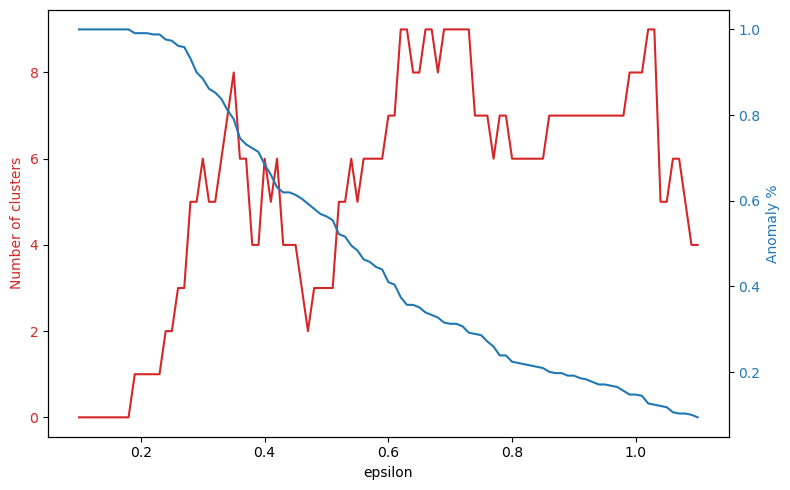

In [135]:
draw_anomaly_plot(X1, eps = 0.1,  eps_grow=0.01)

In [ ]:
# def calc_methods_dbscan(embeds, emb_alg, transform, averaging, notes=df_total_notes, eps_list=eps_list):
#     for eps in tqdm(eps_list):
#         dbscan = DBSCAN(eps=eps, min_samples=3)
#         bank_cluster, embed_labels = clustering_bank(embeds, dbscan, averaging)
#         try:
#             n = np.unique(embed_labels).shape[0]
#             db, ch, ss, bc = calc_metrics(embeds.iloc[:,1:], embed_labels, split_scores(n), bank_cluster)
#             notes.loc[len(notes)+1] = [emb_alg, 'dbscan', transform, n, averaging, db, ch, ss, bc]
#         except:
#             continue

In [62]:
eps_list = [0.2 + 0.01 * x for x in range(100)]

df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'pca_or_tsne','perplexity',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])
for epsilon in eps_list:
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    clustering = dbscan.fit(X1)
    labels = clustering.labels_
    n_clusters=len(set(labels))- (1 if -1 in labels else 0)
    
    silhouette_score = metrics.silhouette_score(X1, labels)
    ch_score = metrics.calinski_harabasz_score(X1, labels)
    db_score = metrics.davies_bouldin_score(X1, labels)

    df_st['labels'] = labels
    print(df_st['labels'].value_counts().reset_index())
    print('============================================')
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

    df_notes.loc[len(df_notes)+1] = ['DBSCAN', False, n_clusters, True, None, None, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed]
    
    

   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    335
1       0      4
   labels  count
0      -1    335
1       0      4
   labels  count
0      -1    331
1       0      4
2       1      4
   labels  count
0      -1    330
1       1      5
2       0      4
   labels  count
0      -1    326
1       1      6
2       0      4
3       2      3
   labels  count
0      -1    325
1       1      7
2       0      4
3       2      3
   labels  count
0      -1    316
1       2      9
2       0      4
3       3      4
4       1      3
5       4      3
   labels  count
0      -1    305
1       2     19
2       0      5
3       1      4
4       4      3
5       3      3
   labels  count
0      -1    300
1       3     20
2       1      6
3       2      4
4       0      3
5       5      3
6       4      3
   labels  count
0      -1    292
1       0     29
2       1      8
3       2      4
4       4      3
5       3     

   labels  count
0       2    202
1      -1    106
2       7      7
3       1      4
4       3      4
5       4      4
6       0      3
7       5      3
8       6      3
9       8      3
   labels  count
0       2    202
1      -1    106
2       7      7
3       1      4
4       3      4
5       4      4
6       0      3
7       5      3
8       6      3
9       8      3
   labels  count
0       2    202
1      -1    104
2       7      7
3       3      6
4       1      4
5       4      4
6       0      3
7       5      3
8       6      3
9       8      3
   labels  count
0       2    203
1      -1     99
2       8      7
3       3      6
4       6      5
5       7      5
6       1      4
7       4      4
8       0      3
9       5      3
   labels  count
0       2    214
1      -1     98
2       6      7
3       3      6
4       1      4
5       4      4
6       0      3
7       5      3
   labels  count
0       2    214
1      -1     97
2       6      7
3       3      6
4       4     

   labels  count
0       0    304
1      -1     31
2       1      4
   labels  count
0       0    304
1      -1     31
2       1      4
   labels  count
0       0    305
1      -1     30
2       1      4
   labels  count
0       0    305
1      -1     30
2       1      4
   labels  count
0       0    305
1      -1     30
2       1      4
   labels  count
0       0    305
1      -1     30
2       1      4


In [190]:
df_total_notes = pd.concat([df_total_notes, df_notes])

### теперь сначала шкалируем данные

In [13]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X1)

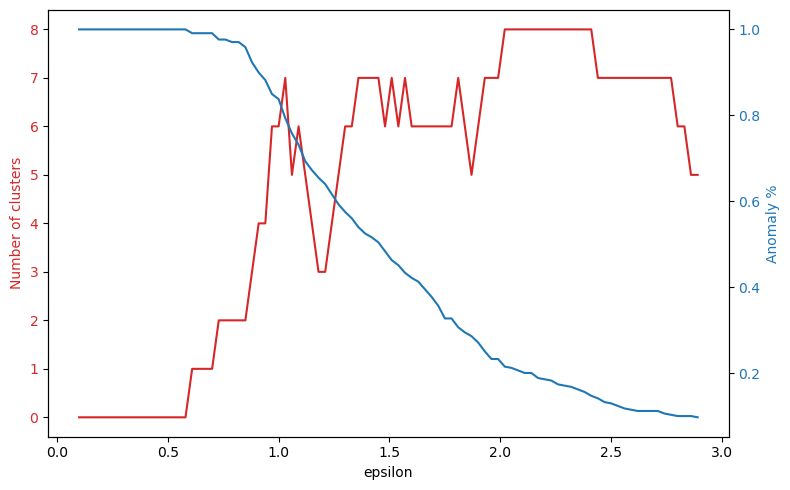

In [204]:
draw_anomaly_plot(X2, eps = 0.1,  eps_grow=0.03)

In [63]:
eps_list = [0.6 + 0.03 * x for x in range(90)]

df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'pca_or_tsne','perplexity',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])
for epsilon in eps_list:
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    clustering = dbscan.fit(X2)
    labels = clustering.labels_
    n_clusters=len(set(labels))- (1 if -1 in labels else 0)
    
    silhouette_score = metrics.silhouette_score(X2, labels)
    ch_score = metrics.calinski_harabasz_score(X2, labels)
    db_score = metrics.davies_bouldin_score(X2, labels)

    df_st['labels'] = labels
    print(df_st['labels'].value_counts().reset_index())
    print('============================================')
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

    df_notes.loc[len(df_notes)+1] = ['DBSCAN', True, n_clusters, True, None, None, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed]
    

   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    336
1       0      3
   labels  count
0      -1    331
1       1      5
2       0      3
   labels  count
0      -1    331
1       1      5
2       0      3
   labels  count
0      -1    331
1       1      5
2       0      3
   labels  count
0      -1    329
1       1      7
2       0      3
   labels  count
0      -1    325
1       1     11
2       0      3
   labels  count
0      -1    317
1       1     13
2       0      3
3       2      3
4       3      3
   labels  count
0      -1    311
1       0     22
2       1      3
3       2      3
   labels  count
0      -1    301
1       1     26
2       0      5
3       3      4
4       2      3
   labels  count
0      -1    292
1       1     28
2       0      7
3       2      5
4       3      4
5       4      3
   labels  count
0      -1    288
1       2     

   labels  count
0       3    240
1      -1     65
2       1     10
3       4      5
4       0      4
5       2      4
6       5      4
7       7      4
8       6      3
   labels  count
0       3    242
1      -1     63
2       1     10
3       4      5
4       0      4
5       2      4
6       5      4
7       7      4
8       6      3
   labels  count
0       3    243
1      -1     62
2       1     10
3       4      5
4       0      4
5       2      4
6       5      4
7       7      4
8       6      3
   labels  count
0       3    244
1      -1     59
2       1     11
3       2      5
4       4      5
5       0      4
6       5      4
7       7      4
8       6      3
   labels  count
0       3    245
1      -1     58
2       1     11
3       2      5
4       4      5
5       0      4
6       5      4
7       7      4
8       6      3
   labels  count
0       3    245
1      -1     58
2       1     11
3       2      5
4       4      5
5       0      4
6       5      4
7       7     

In [210]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [213]:
df_total_notes.to_excel('df_dbscan_result.xlsx', index = False)

# FCM

In [214]:
!pip install scikit-fuzzy

     ---------------------------------------- 0.0/994.0 kB ? eta -:--:--
     ---------------------------------------- 10.2/994.0 kB ? eta -:--:--
      ------------------------------------ 20.5/994.0 kB 217.9 kB/s eta 0:00:05
     - ----------------------------------- 51.2/994.0 kB 375.8 kB/s eta 0:00:03
     ----- ------------------------------ 163.8/994.0 kB 984.6 kB/s eta 0:00:01
     ------------ ------------------------- 327.7/994.0 kB 1.4 MB/s eta 0:00:01
     ----------------- -------------------- 460.8/994.0 kB 1.8 MB/s eta 0:00:01
     ---------------------------------- --- 890.9/994.0 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 994.0/994.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894084 sha256=55d4337a026703238274cf70b0315ec229e46b985277477eaeea6cac87d93ae9
  Stored in directory: c:\us

In [65]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [66]:
# без шкалирования

In [67]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'm',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])

for c in [2, 3, 4, 5, 6, 7, 8]:
    for m in [2 + 10 * x for x in range(10)]:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = X1.T,
                            c = c,
                            m = m,
                            error = 0.01,
                            maxiter = 1000,
                            metric='euclidean',
                            init=None,
                            seed=126)

        labels = np.argmax(u, axis=0)
        silhouette_score = metrics.silhouette_score(X1, labels)
        ch_score = metrics.calinski_harabasz_score(X1, labels)
        db_score = metrics.davies_bouldin_score(X1, labels)

        df_st['labels'] = labels
        print(df_st['labels'].value_counts().reset_index())
        print('============================================')
        df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
        df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
        clusters = df1.T.to_dict('records')[1]

        y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
        precision_bcubed = bcubed.precision(y_pred, y_true)
        recall_bcubed = bcubed.recall(y_pred, y_true)
        fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

        df_notes.loc[len(df_notes)+1] = ['fuzzy C-means', False, c, True, m, 
                                                           db_score, ch_score, silhouette_score, fscore_bcubed]    

   labels  count
0       1    289
1       0     50
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       0    240
1       1     99
   labels  count
0       1    260
1       2     78
2       0      1
   labels  count
0       2    230
1       0     98
2       1     11
   labels  count
0       2    230
1       0     98
2       1     11
   labels  count
0       2    229
1       0     95
2       1     15
   labels  count
0       2    228
1       0     95
2       1     16
   labels  count
0       2    226
1       0     93
2       1     20
   labels  count
0       2    197
1       0     92
2       1     50
   labels  cou

   labels  count
0       1    229
1       6     79
2       0     18
3       3     10
4       5      2
5       2      1
   labels  count
0       1    208
1       0    103
2       3     15
3       6      6
4       5      3
5       4      2
6       2      1
7       7      1
   labels  count
0       1    174
1       3    110
2       2     27
3       0     13
4       5      7
5       6      4
6       7      3
7       4      1
   labels  count
0       1    112
1       3    109
2       7     64
3       2     22
4       5     13
5       0     12
6       6      4
7       4      3
   labels  count
0       7    107
1       3    102
2       1     70
3       2     21
4       5     21
5       0     12
6       6      4
7       4      2
   labels  count
0       3    104
1       1    101
2       7     76
3       5     21
4       2     19
5       0      9
6       4      5
7       6      4
   labels  count
0       1    109
1       3    105
2       7     71
3       2     19
4       5     13
5       0     

In [284]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [286]:
# с шкалированием

In [68]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'm',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])

for c in [2, 3, 4, 5, 6, 7, 8]:
    for m in [2 + 10 * x for x in range(10)]:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = X2.T,
                            c = c,
                            m = m,
                            error = 0.01,
                            maxiter = 1000,
                            metric='euclidean',
                            init=None,
                            seed=126)

        labels = np.argmax(u, axis=0)
        silhouette_score = metrics.silhouette_score(X2, labels)
        ch_score = metrics.calinski_harabasz_score(X2, labels)
        db_score = metrics.davies_bouldin_score(X2, labels)

        df_st['labels'] = labels
        print(df_st['labels'].value_counts().reset_index())
        print('============================================')
        df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
        df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
        clusters = df1.T.to_dict('records')[1]

        y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
        precision_bcubed = bcubed.precision(y_pred, y_true)
        recall_bcubed = bcubed.recall(y_pred, y_true)
        fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

        df_notes.loc[len(df_notes)+1] = ['fuzzy C-means', True, c, True, m, 
                                                           db_score, ch_score, silhouette_score, fscore_bcubed]    

   labels  count
0       1    184
1       0    155
   labels  count
0       0    189
1       1    150
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       0    188
1       1    151
   labels  count
0       1    177
1       0    136
2       2     26
   labels  count
0       1    184
1       2    155
   labels  count
0       1    184
1       2    153
2       0      2
   labels  count
0       1    183
1       2    153
2       0      3
   labels  count
0       1    181
1       2    153
2       0      5
   labels  count
0       1    180
1       2    152
2       0      7
   labels  count
0       1    179
1       2    150
2       0     10
   labels  count
0       1    1

   labels  count
0       1    155
1       7    141
2       2     17
3       0      9
4       5      7
5       4      4
6       3      3
7       6      3
   labels  count
0       1    149
1       7    134
2       2     17
3       5     14
4       0      9
5       4      8
6       3      5
7       6      3
   labels  count
0       1    146
1       7    133
2       2     17
3       5     15
4       4     10
5       0      9
6       3      6
7       6      3
   labels  count
0       1    143
1       7    131
2       2     17
3       5     17
4       4     12
5       0      9
6       3      7
7       6      3
   labels  count
0       1    151
1       7    136
2       2     17
3       5     14
4       0      9
5       4      6
6       3      3
7       6      3
   labels  count
0       1    146
1       7    131
2       5     19
3       2     17
4       4     10
5       0      9
6       3      4
7       6      3


In [290]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [291]:
df_total_notes.to_excel('df_fcm_result.xlsx', index = False)

# Спектральная кластеризация

In [21]:
from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph

n_cluster = [2,3,4,5,6,7,8]

def draw_eigh(embeds, n):
    spectr = SpectralClustering(n_clusters=n, n_components=n, random_state=42)
    spectr.fit(embeds)
    L = csgraph.laplacian(spectr.affinity_matrix_)
    values, vectors = np.linalg.eigh(L)
    sns.lineplot(sorted(values[:10]))
    plt.plot()
    plt.ylabel('Eigenvalues')
    plt.xlabel('Numer of vectors')

def calc_methods_spectral(embeds, emb_alg, transform, averaging, notes):
    for n in tqdm(n_cluster):
        spectr = SpectralClustering(n_clusters=n, n_components=n)
        bank_cluster, embed_labels = clustering_bank(embeds, spectr, averaging)
        db, ch, ss, bc = calc_metrics(embeds, embed_labels, split_scores(n), bank_cluster)
        notes.loc[len(notes)+1] = [emb_alg, 'spectr', transform, n, averaging, db, ch, ss, bc]

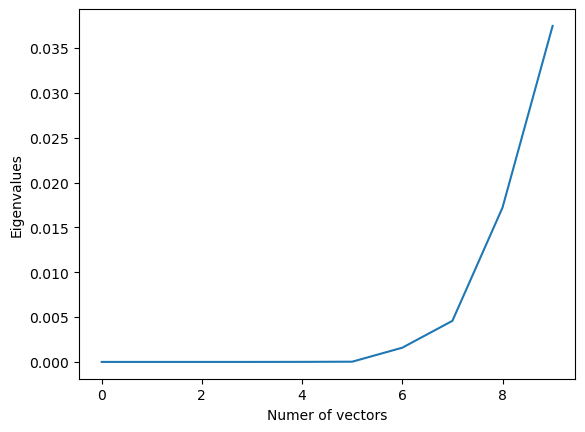

In [69]:
draw_eigh(X1, n=4)

In [ ]:
# не работает для масштабированной выборки

In [71]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])

n_clusters_list = [2,3,4,5,6,7,8]
for n in n_clusters_list:
    spectr = SpectralClustering(n_clusters=n, n_components=n)
    spectr.fit(X1)
    labels = spectr.labels_
    
    silhouette_score = metrics.silhouette_score(X1, labels)
    ch_score = metrics.calinski_harabasz_score(X1, labels)
    db_score = metrics.davies_bouldin_score(X1, labels)
    
    df_st['labels'] = labels
    print(df_st['labels'].value_counts().reset_index())
    print('============================================')
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

    df_notes.loc[len(df_notes)+1] = ['Spectral', False, n, True, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed]

   labels  count
0       0    335
1       1      4
   labels  count
0       0    333
1       1      4
2       2      2
   labels  count
0       0    320
1       3     13
2       1      4
3       2      2
   labels  count
0       0    317
1       3     13
2       1      4
3       4      3
4       2      2
   labels  count
0       0    320
1       4      7
2       1      4
3       5      3
4       2      3
5       3      2
   labels  count
0       0    321
1       2      4
2       1      4
3       5      3
4       4      3
5       6      2
6       3      2
   labels  count
0       0    304
1       6     17
2       2      4
3       1      4
4       7      3
5       5      3
6       4      2
7       3      2


In [72]:
df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed
1,Spectral,False,2,True,0.513711,3.169033,0.673626,0.666676
2,Spectral,False,3,True,0.498919,1.940123,0.527189,0.499030
3,Spectral,False,4,True,0.901667,2.013151,0.431338,0.413996
4,Spectral,False,5,True,0.928931,1.605791,0.307144,0.345813
5,Spectral,False,6,True,0.859804,1.261293,0.277368,0.308959
6,Spectral,False,7,True,0.719931,1.056953,0.270926,0.296361
7,Spectral,False,8,True,0.846420,1.185510,0.277449,0.279287


In [74]:
# df_total_notes = pd.read_excel('df_fcm_result.xlsx')

In [76]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [78]:
df_total_notes.to_excel('df_spectral_result.xlsx', index = False)

# Анализ кластеров